# GSEA analysis

## IS-GSEA

In [157]:
library('fgsea')
library('msigdbr')
library('ggplot2')

In [107]:
paths <- list( 'KO-Y'='subdata/IS_results_KO::young.csv', 
               'WT-Y'='subdata/IS_results_WT::young.csv', 
               'old-Y'='subdata/IS_results_old::young.csv',
               'KO-WT'='subdata/IS_results_KO::WT.csv',
               'old-WT'='subdata/IS_results_old::WT.csv',
               'DE:old-Y'='subdata/DE_results_old::young.csv')

In [147]:
species = 'mouse'
type = 'Symbol'

#fetch gene sets
m_df_h = msigdbr(species = species, category = "H")
m_df_bp = msigdbr(species = species, category = "C5",subcategory = "BP")
m_df_kegg = msigdbr(species = species, category = "C2",subcategory = "CP:KEGG")
m_df_reactome = msigdbr(species = species, category = "C2",subcategory = "CP:REACTOME")
m_df <- m_df_h#rbind(rbind(m_df_h, m_df_bp,m_df_kegg),m_df_reactome)
#prepare gene sets
functions_list <- levels(factor(m_df$gs_name))
functions_annotation <- list()
for (i in functions_list){
    temp_data <- m_df[m_df$gs_name==i,]
    if (type=="Symbol"){
        temp_data <- toupper(as.character(temp_data$gene_symbol))
    }else if (type=="Entrez"){
        temp_data <- as.character(temp_data$entrez_gene)      
    }
    functions_annotation[[i]] <- temp_data
}

ds <- list()
fres <- list()
for (path in names(paths)){
    IS <- read.csv(paths[[path]])
    ranked_list <- IS[c('Name', 'ES')]
    ranked_list <- ranked_list[order(ranked_list[,2],decreasing = T),]
    ranked_vector <- ranked_list[,2]
    names(ranked_vector) <- toupper(as.character(ranked_list[,1]))
    
    res <- fgsea(pathways = functions_annotation, 
                stats    = ranked_vector,
                nperm = 10000,
                minSize  = 10,
                maxSize  = 500)
    fres[[path]] <- res
    ds[[path]] <- IS
}


Warning message in fgsea(pathways = functions_annotation, stats = ranked_vector, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (23.9% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgsea(pathways = functions_annotation, stats = ranked_vector, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (23.9% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in

In [148]:
nesdf <- data.frame(row.names=fres[['KO-Y']]$pathway)
merge(nesdf, fres[[6]][,c('pathway','NES')], by.x='row.names', by.y='pathway')

Row.names,NES
<I<chr>>,<dbl>
HALLMARK_ADIPOGENESIS,0.9371357
HALLMARK_ALLOGRAFT_REJECTION,-1.0087983
HALLMARK_ANDROGEN_RESPONSE,-0.9560593
HALLMARK_ANGIOGENESIS,-1.4203573
HALLMARK_APICAL_JUNCTION,-1.4931734
HALLMARK_APICAL_SURFACE,-1.1365987
HALLMARK_APOPTOSIS,-0.9975508
HALLMARK_BILE_ACID_METABOLISM,-0.8000204
HALLMARK_CHOLESTEROL_HOMEOSTASIS,-1.2371639


NES

Using rowname as id variables

Using rowname as id variables



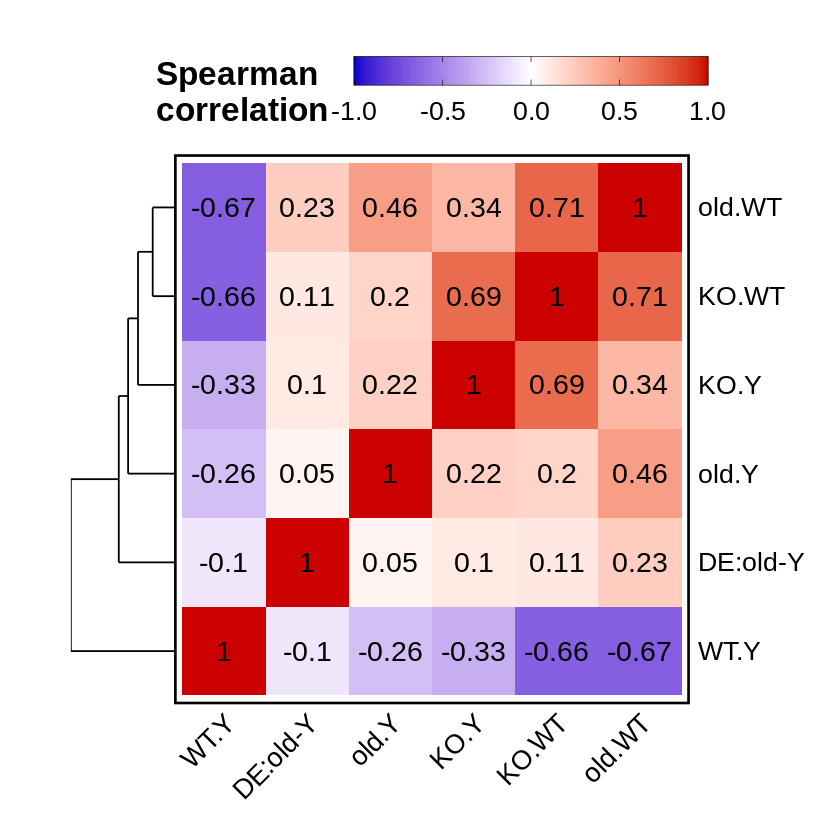

In [149]:
nesdf <- data.frame(row.names=fres[['KO-Y']]$pathway)
pdf <- data.frame(row.names=fres[['KO-Y']]$pathway)
disdf <- data.frame(row.names=ds[['KO-Y']]$Name)
for (n in names(fres)){
    #disdf[n] <- ds[[n]]$FC
    nesdf <- transform(merge(nesdf, fres[[n]][,c('pathway','NES')], by.x='row.names', by.y='pathway'),
                       row.names=Row.names, Row.names=NULL)
    colnames(nesdf)[colnames(nesdf) == "NES"] <- n
    
    pdf <- transform(merge(pdf, fres[[n]][,c('pathway','pval')], by.x='row.names', by.y='pathway'),
                       row.names=Row.names, Row.names=NULL)
    colnames(pdf)[colnames(pdf) == "pval"] <- n

    #pdf[n] <- fres[[n]]$pval 
}

cat('NES')
source('utils/ggcorplot.R')
options(repr.plot.width = 7, repr.plot.height = 7)
p <- ggheatmap(nesdf, method='spearman')
cowplot::plot_grid(p)

# cat('diff-IS')
# source('utils/ggcorplot.R')
# options(repr.plot.width = 7, repr.plot.height = 7)
# p <- ggheatmap(disdf)
# cowplot::plot_grid(p)

In [173]:
for (name in names(fres)){
    fres[[name]] <- as.data.frame(fres[[name]])
    rownames(fres[[name]]) <- fres[[name]]$pathway
}

Using rowname as id variables

Using rowname as id variables



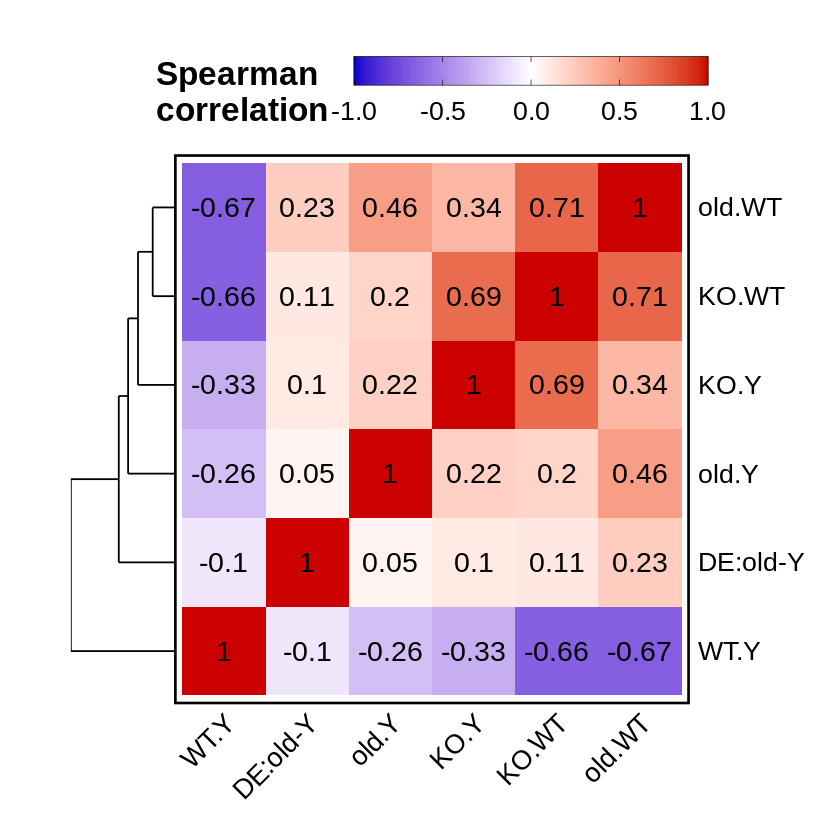

In [207]:
source('utils/ggcorplot.R')
options(repr.plot.width = 7, repr.plot.height = 7)
p <- ggheatmap(nesdf, type='full_intersection', method='spearman', top=2500,
                measure="NES", criterion="padj", criterion_thr=1.0)
cowplot::plot_grid(p)

In [212]:
nm1 <- rownames(pdf[order(pdf[['KO.Y']]),][1:10,])
nm2 <- rownames(pdf[order(pdf[['old.Y']]),][1:10,])
nm3 <- rownames(pdf[order(pdf[['WT.Y']]),][1:10,])

nm <- unique(c(nm1, nm2, nm3))

# nm <- rownames(nesdf[sign(nesdf$old) != sign(nesdf$WT),])
# print(length(nm))
# tmp <- pdf[nm,]
# nm <- rownames(tmp[order(tmp$WT),][1:20,])

In [209]:
melt <- data.frame()
for (n in names(fres)){
    fres[[n]]$type <- n
    melt <- rbind(melt, fres[[n]])
}

In [213]:
#submelt <- melt[grepl('HALLMARK', melt$pathway),]
submelt <- melt[melt$pathway %in% nm,]

In [154]:
#submelt$pathway <- factor(submelt$pathway, levels=nm)

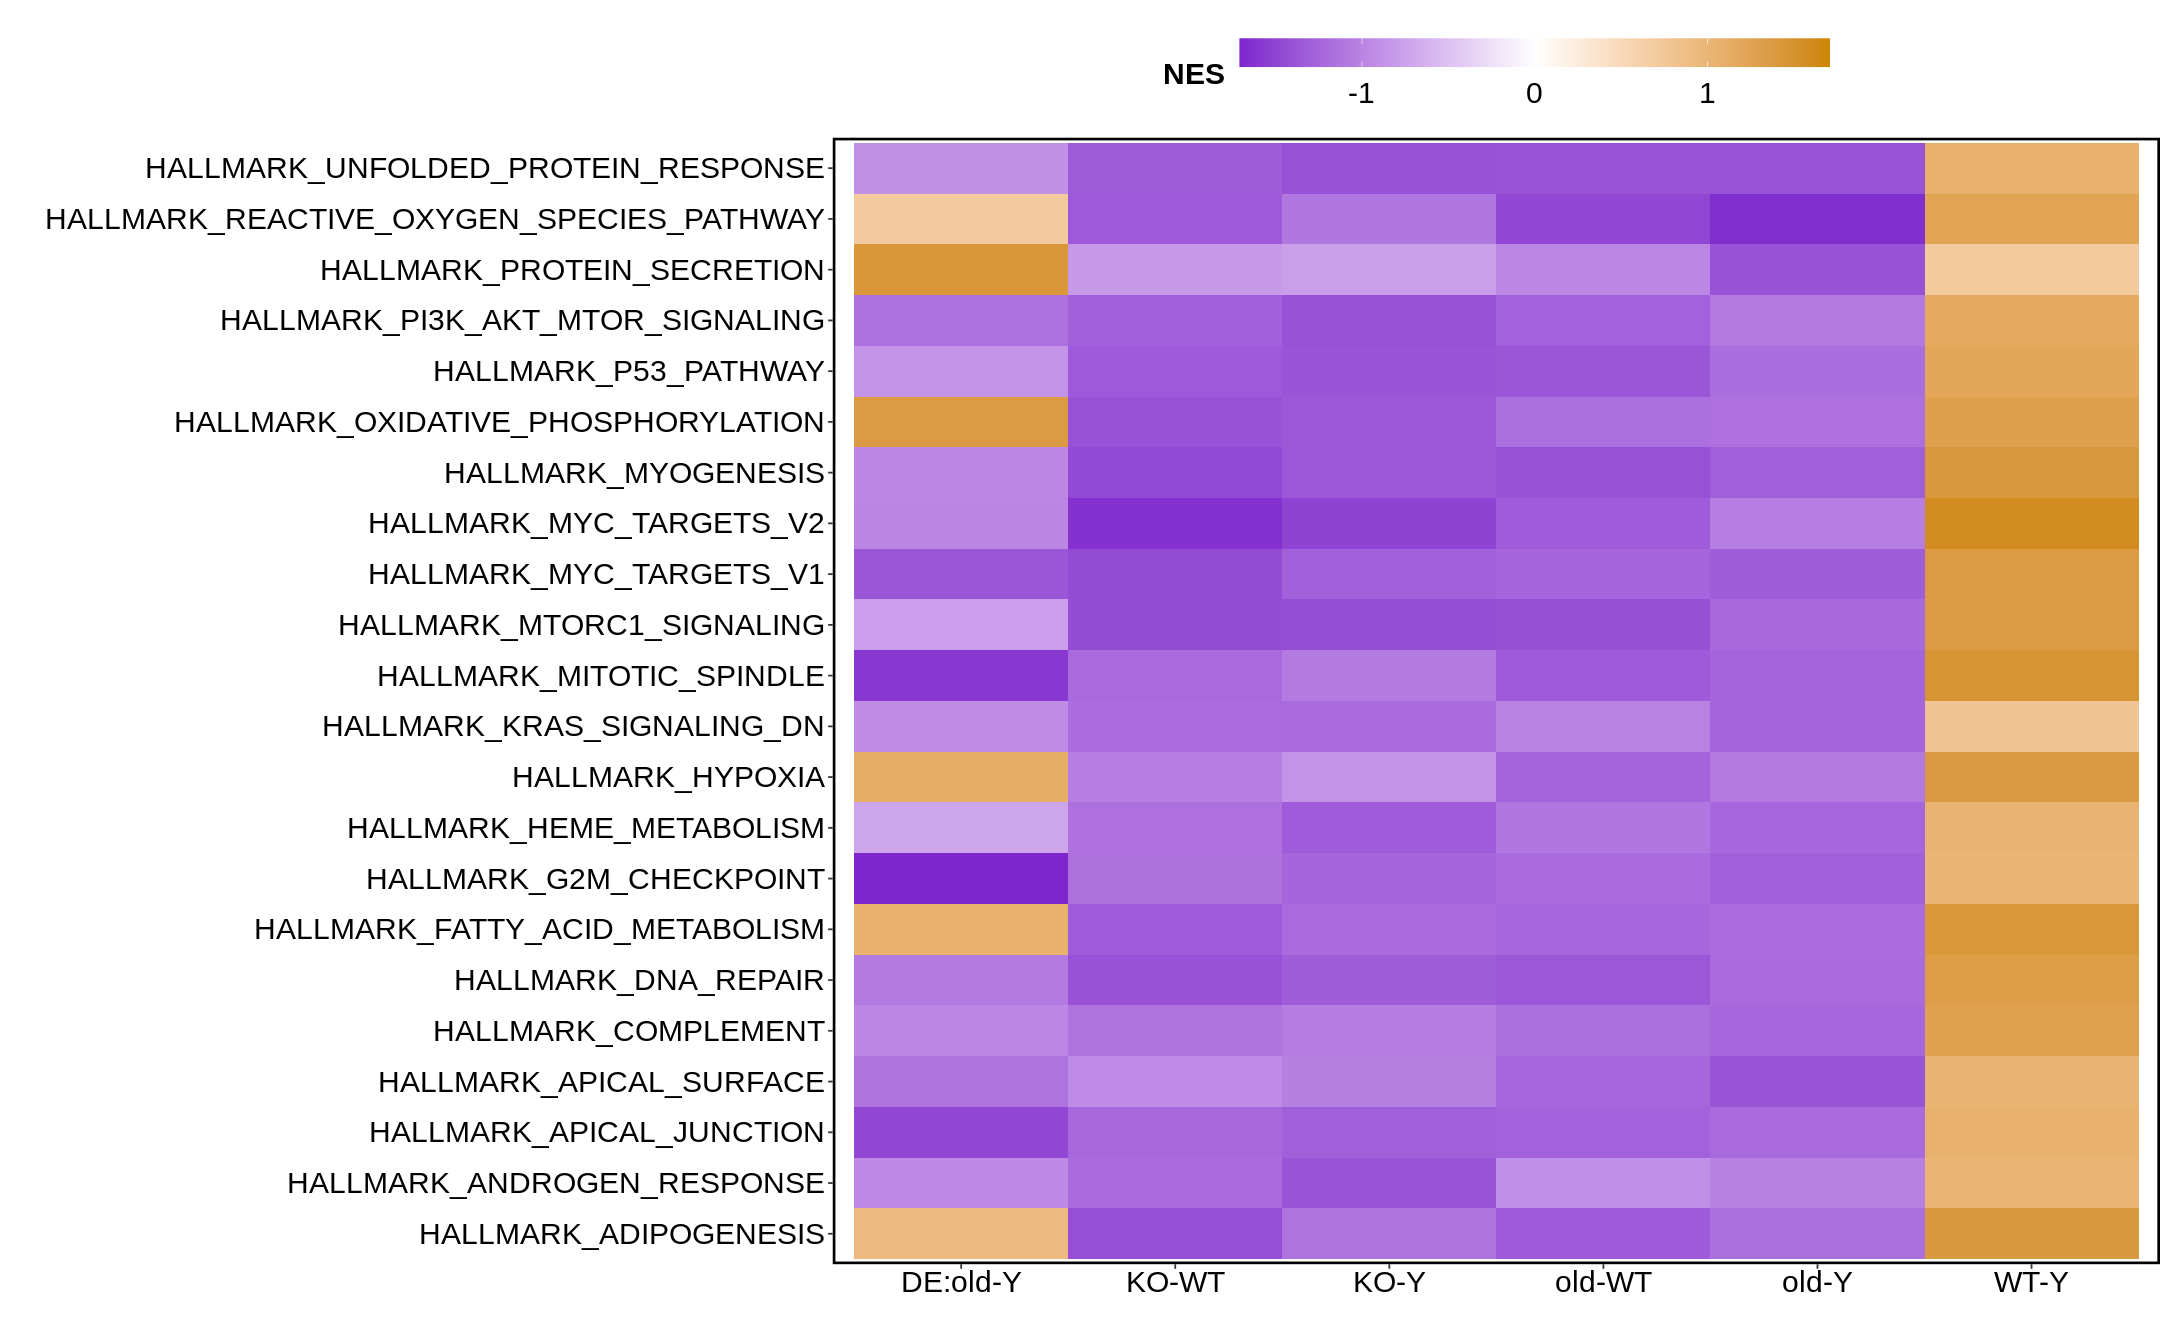

In [214]:
fontsize=18
limit <- max(abs(submelt$NES))
options(repr.plot.width = 18, repr.plot.height = nrow(submelt)/3/4)
ggplot(data=submelt, aes(x=type, y=pathway, fill=NES)) + 
    geom_tile()+
    theme(
        axis.text.y = element_text(size = fontsize, colour='black'),
        axis.text.x = element_text(size = fontsize, colour='black'),
        panel.background = element_rect(fill='white', colour='black', size=1.5, linetype='solid'),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.title=element_text(size=fontsize, face = "bold"),
        legend.text=element_text(size=fontsize),
        legend.position="top", 
        legend.key.width = unit(2.5, "cm"),
        plot.margin = unit(c(0., 0., 0., 0.5), "cm")) +
    scale_fill_gradient2(
                        high="orange3", low="purple3", mid='white', 
                        limits=c(-limit, limit), 
                        midpoint=0)+
    labs(x="", y = "", title="")

# RLE normalization

In [59]:
df <- read.csv('/tank/projects/kriukov_chromatin/RNA/GSE129788/pseudoBulk_counts.csv', row.names=1)

In [39]:
source('utils/RLE_norm.R')

In [40]:
#Perform sample normalzation 
rle_df <- log2(RLE_normalization(df) + 1)

write.csv(rle_df, '/tank/projects/kriukov_chromatin/RNA/GSE129788/pseudoBulk_logRLE.csv')

In [68]:
library(edgeR)
library(ggplot2)
suppressMessages(library(DESeq2))

In [61]:
data <- df
genotype <- factor(c(rep("old",8), rep("young", 8) ))
meta <- data.frame(genotype, row.names = colnames(data))

In [64]:
# Create DESeq2Dataset object:
dds <- DESeqDataSetFromMatrix(countData = data, colData = meta, design = ~1)

#Perform normalization and filter genes with low expression (delete gene if there is less than 3 samples with
#less than 5 counts):
dds <- estimateSizeFactors(dds)
idx <- rowSums(counts(dds, normalized=TRUE) >= 10 ) >= 8
dds <- dds[idx,]

In [66]:
# Perform rlog-transformation:
rld <- rlog(dds, blind=TRUE)

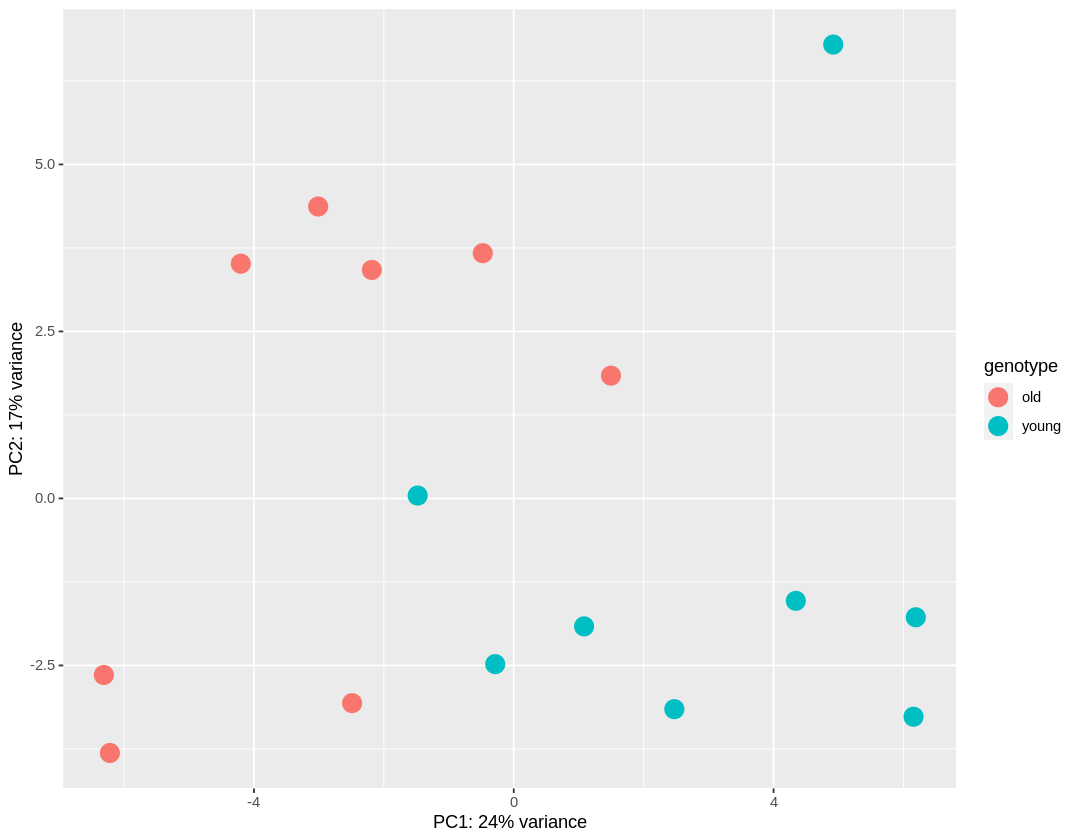

In [69]:
options(repr.plot.width=9, repr.plot.height=7)
pcaData <- plotPCA(rld,
                intgroup=c("genotype"),
                returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
ggplot(pcaData, aes(PC1, PC2, color=genotype)) +
geom_point(size=5) +
xlab(paste0("PC1: ",percentVar[1],"% variance")) +
ylab(paste0("PC2: ",percentVar[2],"% variance"))
ggsave('PCA_plot.png', height = 9, width = 11.5)

In [71]:
#DE analysis
dds_factors <- DESeqDataSetFromMatrix(countData = data, colData = meta, design = ~ genotype)

In [73]:
#Filter genes with low expression:
dds_factors <- estimateSizeFactors(dds_factors)
idx <- rowSums(counts(dds_factors, normalized=TRUE) >= 10 ) >= 8
dds_factors <- dds_factors[idx,]
dds_factors <- DESeq(dds_factors)

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [82]:
contrast <- c("genotype", 'old', 'young')
#Perform statistical analysis:
res_unshrunken <- results(dds_factors, contrast=contrast, alpha = 0.05)
#Perform lfc-shrinkage:
res <- lfcShrink(dds=dds_factors, contrast=contrast, res=res_unshrunken, type='normal')

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



In [86]:
dif <- as.data.frame(res)

In [92]:
dif$ES <- -log10(dif$pvalue) * dif$log2FoldChange
colnames(dif) <- c('mean', 'FC', 'SE', 'stat', 'pval', 'padj', 'ES')

In [103]:
write.csv(dif, 'subdata/DE_results_old::young.csv')